Generated partially with ChatGPT (chat.openai.com).


In [1]:
import gc
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [55]:
# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


# Define the dataset
class MoGData(object):
  def __init__(self, dimension=2, num_classes=2, magnitude=10):
    # Define the parameters for the two Gaussian distributions
    self.dimension = dimension
    self.num_classes = num_classes
    self.magnitude = magnitude
    self.mu = np.zeros((num_classes, dimension))
    self.sigma = np.zeros((num_classes, dimension, dimension))
    self.distrib = []

    for i in range(num_classes):
      for j in range(dimension):
        self.mu[i, j] = np.random.uniform(-self.magnitude, self.magnitude)
      # Identity matrix for variance
      self.sigma[i] = np.eye(dimension)  
      self.distrib.append(multivariate_normal(mean=self.mu[i], cov=self.sigma[i]))

  def sample_data(self, num_samples = 10000):
    # Generate samples from the two Gaussian distributions
    samples = []
    for i in range(self.num_classes):
      samples.append(np.random.multivariate_normal(self.mu[i], self.sigma[i], num_samples))

    # Combine the samples and create labels
    data = np.concatenate(samples).astype(np.float32)
    labels = np.concatenate([[i]*num_samples for i in range(self.num_classes)]).astype(int)

    # Shuffle the data and labels together
    combined = list(zip(data, labels))
    data[:], labels[:] = zip(*combined)
    return data, labels
  
  def plot(self, num_samples):
    data, labels = self.sample_data(num_samples)
    # size (6,6)
    fig = plt.figure(figsize=(6,6))
    
    if self.dimension == 3:
      ax = fig.add_subplot(111, projection='3d')
      for i in range(self.num_classes):
        samples = data[labels==i]
        color = np.random.rand(3)
        ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2], c=[color], label='class '+str(i), alpha=0.05)
      plt.legend()
      plt.show()
    elif self.dimension == 2:
      for i in range(self.num_classes):
        samples = data[labels==i]
        if i ==9:
          color = 'purple'
        else:
          color = np.random.rand(3)
        plt.scatter(samples[:, 0], samples[:, 1], c=color, label='class '+str(i), alpha=0.4)
      plt.legend()
      plt.tick_params(axis='both', which='major', labelsize=12)
      plt.show()
    else:
      print("Dimension not supported")
    save_name = 'dataset.pdf'
    fig.savefig(save_name)

  def compute_likelihood_ratio(self, labels, data_points):
    """p(y=0|x), assuming p(y=0)=p(y=1)=0.5"""
    # 计算所有数据点在每个类别分布下的pdf值
    distances = np.array([self.distrib[j].pdf(data_points) for j in range(self.num_classes)]).T
    
    # 获取每个数据点对应类别的pdf值
    gt_probs = distances[np.arange(data_points.shape[0]), labels] / distances.sum(axis=1)
    
    return gt_probs, distances

In [3]:
def set_seed(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(seed)
  random.seed(seed)

seed:  70


/tmp/ipykernel_4027784/687080749.py:67: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(samples[:, 0], samples[:, 1], c=color, label='class '+str(i), alpha=0.4)


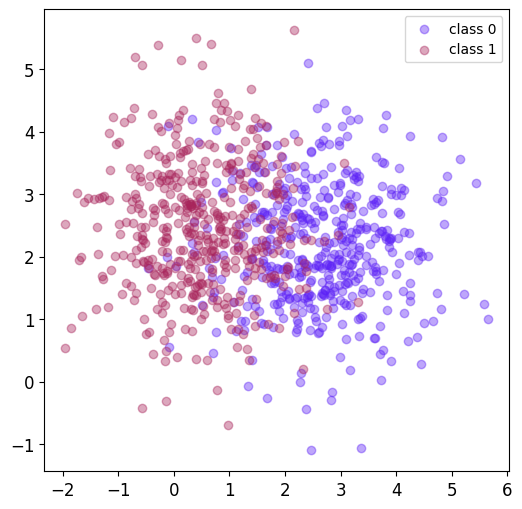

In [72]:
# Dataset Initialization
seed = random.randint(0, 100)
print("seed: ", seed)
set_seed(seed)

num_samples = 10000
batch_size = 1000
dimension = 2
num_classes = 2
magnitude = 3

mog_data = MoGData(dimension=dimension, num_classes=num_classes, magnitude=magnitude)
mog_data.plot(num_samples=450)
train_loader = DataLoader(CustomDataset(*mog_data.sample_data(num_samples=num_samples)),
                          batch_size=batch_size,
                          shuffle=True, num_workers=0)
# generate a test dataset from the distribution
test_data, test_labels = mog_data.sample_data(num_samples=1000)
test_gt_probs, test_distances = mog_data.compute_likelihood_ratio(test_labels, test_data)
test_labels = torch.from_numpy(test_labels).long().cuda()
test_gt_probs = torch.from_numpy(test_gt_probs).cuda()

test_data_tensor = torch.from_numpy(test_data).cuda()

In [5]:
# Define the DNN model
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        
        return out

In [6]:
def show(test_gt_probs, confidence, save_name):
    #  test_gt_probs to numpy
    test_gt_probs = test_gt_probs.detach().cpu().numpy()
    # confidence to numpy
    confidence = confidence.detach().cpu().numpy()

    # 将概率区间划分为 15 个区间
    bins = np.linspace(0, 1, 16)

    # 计算每个区间的中位数和平均 confidence
    median_probs = []
    mean_confidence = []

    for i in range(len(bins) - 1):
        # 获取属于当前区间的索引
        idx = (test_gt_probs >= bins[i]) & (test_gt_probs < bins[i + 1])
        
        # 计算该区间的中位数和均值
        # if np.sum(idx) > 0:
        median_probs.append((bins[i] + bins[i + 1]) / 2)
        mean_confidence.append(np.mean(confidence[idx]))
        # else:
        #     median_probs.append(0)
        #     mean_confidence.append(0)

    # 设置柱状图的位置
    x = np.arange(len(median_probs))
    width = 0.5

    # 绘制柱状图
    fig, ax = plt.subplots(figsize=(6, 6))
    rects1 = ax.bar(x, median_probs, width, color='pink', label='Expected Confidence')
    rects2 = ax.bar(x, mean_confidence, width, color='blue', label='Observed Confidence', alpha=0.5)

    # 添加图表信息
    # 标签字号大小
    ax.tick_params(labelsize=15)
    ax.set_xlabel('Confidence', fontsize=15)
    ax.set_ylabel('Confidence', fontsize=15)
    ax.set_xticks([0, len(median_probs) // 2, len(median_probs) - 1])
    ax.set_xticklabels(['0.0', '0.5', '1.0'], fontsize=15)
    ax.legend(fontsize=15)

    # 显示图表
    plt.tight_layout()
    plt.show()

    # save as pdf
    fig.savefig(save_name)
    


In [60]:
# Define custom loss functions
class CrossEntropy(nn.Module):
    def __init__(self):
        super(CrossEntropy, self).__init__()

    def forward(self, input, target):

        target = target.view(-1, 1)
        logpt = F.log_softmax(input, dim=1)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1)
        loss = -1 * logpt

        return loss.mean()


class CrossEntropyProb(nn.Module):
    def __init__(self, gamma=2):
        super(CrossEntropyProb, self).__init__()
        self.gamma = gamma
    def forward(self, input, target, gt_prob):

        target = target.view(-1,1)
        logpt = F.log_softmax(input, dim=1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)

        pt = logpt.exp()

        weight = (gt_prob - pt).abs()**self.gamma
        # print(weight.shape)
        
        loss = -1 * weight * logpt

        return loss.mean()

90it [00:00, 482.32it/s]              

Epoch:  0 Loss:  0.41833367943763733
Epoch:  1 Loss:  0.35119813680648804
Epoch:  2 Loss:  0.35661354660987854
Epoch:  3 Loss:  0.37043026089668274
Epoch:  4 Loss:  0.34244677424430847
Epoch:  5 Loss:  0.34941670298576355
Epoch:  6 Loss:  0.33544445037841797


200it [00:00, 552.73it/s]


Epoch:  7 Loss:  0.3160910904407501
Epoch:  8 Loss:  0.3685520589351654
Epoch:  9 Loss:  0.3439270853996277
Cross Entropy Consistency:  0.007407066144559352
Cross Entropy Accuracy:  0.8500000238418579


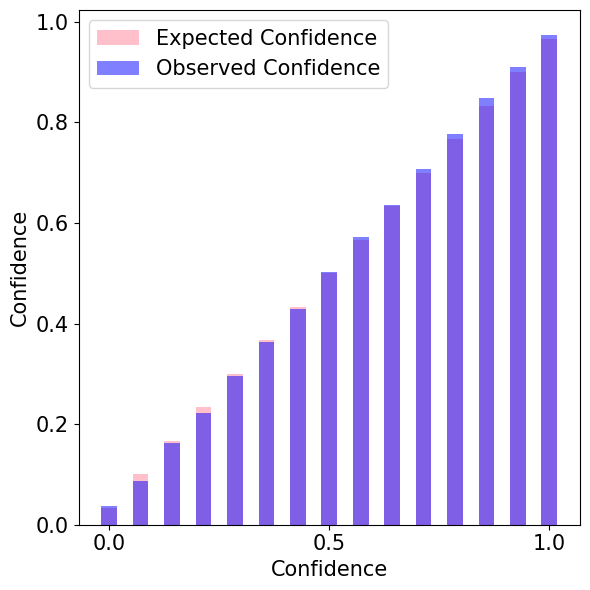

In [73]:
learning_rate = 0.3

# Training the model with cross entropy loss
model_ce = DNN(dimension, 100, num_classes).cuda()  # Move model to GPU
ce = CrossEntropy().cuda()  # Move loss function to GPU
optimizer_ce = optim.SGD(model_ce.parameters(), lr=learning_rate)
pbar_ce = tqdm(total=len(train_loader))
for epoch in range(10):
  for i, (inputs, labels) in enumerate(train_loader):
    inputs, labels = inputs.cuda(), labels.cuda()  # Move data to GPU
    optimizer_ce.zero_grad()
    outputs = model_ce(inputs)
    loss_ce = ce(outputs, labels)
    loss_ce.backward()
    optimizer_ce.step()
    pbar_ce.update(1)
  print("Epoch: ", epoch, "Loss: ", loss_ce.item())
pbar_ce.close()

test_outputs_ce = model_ce(test_data_tensor)
prob_ce = F.softmax(test_outputs_ce, dim=1)
confidence_ce = prob_ce.gather(1, test_labels.unsqueeze(1)).squeeze(1)
calibrated_error_ce = test_gt_probs - confidence_ce

print("Cross Entropy Consistency: ", calibrated_error_ce.abs().mean().item())

accuracy = (prob_ce.argmax(dim=1) == test_labels).float().mean().item()
print("Cross Entropy Accuracy: ", accuracy)
show(test_gt_probs, confidence_ce, 'output_ce1.pdf')

  0%|          | 0/20 [00:00<?, ?it/s]

76it [00:00, 405.03it/s]              

Epoch:  0 Loss:  0.03880669797457565
Epoch:  1 Loss:  0.03921110417805195
Epoch:  2 Loss:  0.02434668663703588
Epoch:  3 Loss:  0.03591654287951305


200it [00:00, 462.44it/s]

Epoch:  4 Loss:  0.021522175461857935
Epoch:  5 Loss:  0.013762312175129493
Epoch:  6 Loss:  0.020943749473620727
Epoch:  7 Loss:  0.017733124624197523
Epoch:  8 Loss:  0.015708597337522327
Epoch:  9 Loss:  0.014417555249531467
gamma:  1 Cross Entropy Probability Consistency:  0.0508779956299775
Accuracy:  0.8460000157356262


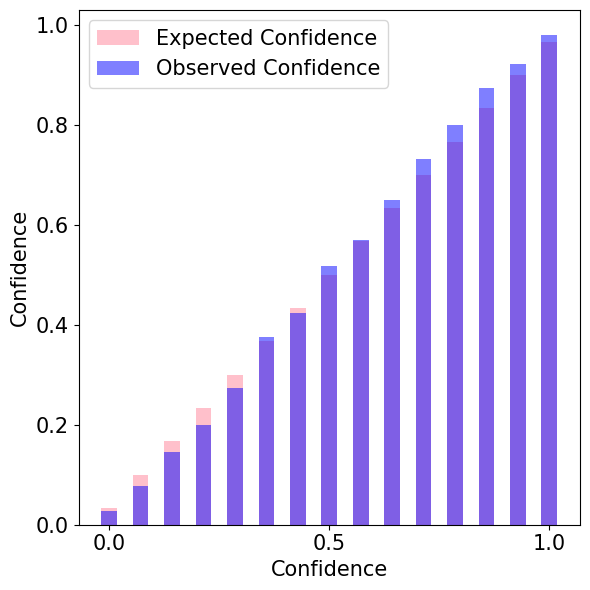

In [78]:

# from 1 to 10, step 0.1
gamma_list = [1]

for gamma in gamma_list:
  # Training the model with cross entropy probability loss
  model_ce_prob = DNN(dimension, 100, num_classes).cuda()
  optimizer_ce_prob = optim.SGD(model_ce_prob.parameters(), lr=learning_rate)
  pbar_ce_prob = tqdm(total=len(train_loader))
  ce_prob = CrossEntropyProb(gamma=gamma).cuda()

  for epoch in range(10):
    for i, (inputs, labels) in enumerate(train_loader):
      inputs = inputs.cuda()
      labels = labels.cuda()
      optimizer_ce_prob.zero_grad()
      outputs = model_ce_prob(inputs)
      # print(outputs[0])
      # print(labels[0])
      gt_probs, gt_distances = mog_data.compute_likelihood_ratio(labels.cpu(), inputs.cpu()) 
      gt_probs = torch.from_numpy(gt_probs).cuda()
      loss_prob = ce_prob(outputs, labels, gt_probs)
      loss_prob.backward()
      optimizer_ce_prob.step()
      pbar_ce_prob.update(1)
    print("Epoch: ", epoch, "Loss: ", loss_prob.item())
  pbar_ce_prob.close()

  test_outputs_ce_prob = model_ce_prob(test_data_tensor)
  prob_ce_prob = F.softmax(test_outputs_ce_prob, dim=1)
  confidence = prob_ce_prob.gather(1, test_labels.unsqueeze(1)).squeeze(1) 
  calibrated_error_ce_prob = test_gt_probs - confidence

  print("gamma: ", gamma, "Cross Entropy Probability Consistency: ", calibrated_error_ce_prob.abs().mean().item())
  accuracy = (prob_ce_prob.argmax(dim=1) == test_labels).float().mean().item()
  print("Accuracy: ", accuracy)
  show(test_gt_probs, confidence, 'output_ce_prob1.pdf')

  # del model_ce_prob, ce_prob, optimizer_ce_prob, pbar_ce_prob, test_outputs_ce_prob, prob_ce_prob, calibrated_error_ce_prob
  # gc.collect()
  # torch.cuda.empty_cache()

In [33]:
normalized_test_distances = test_distances / test_distances.sum(axis=1, keepdims=True)
print(normalized_test_distances[0])
print(test_distances[0])
print(test_gt_probs[0])



[0.02187875 0.07958888 0.23276338 0.02222553 0.0313039  0.15199143
 0.15823853 0.10705007 0.18278787 0.01217167]
[0.01231412 0.04479539 0.13100732 0.0125093  0.01761892 0.08554606
 0.08906215 0.0602515  0.10287937 0.00685064]
tensor(0.0219, device='cuda:0', dtype=torch.float64)


In [76]:
class SoftCE(nn.Module):
    def __init__(self, gamma=2):
        super(SoftCE, self).__init__()
        self.gamma = gamma

    def forward(self, input, target, gt_distances, gt_probs):
        logpt_N = F.log_softmax(input, dim=1)
        
        target = target.view(-1,1)
        pt_distribution = F.softmax(input, dim=1)
        logpt = logpt_N.gather(1,target)
        logpt = logpt.view(-1)
        pt = logpt.exp()

        # 计算损失时使用 gt_distances 作为 soft label
        with torch.no_grad():
            weight = (gt_probs - pt).abs()**self.gamma
        loss = -1 * gt_distances * logpt_N

        loss = loss.mean(dim=1) * weight


        return loss.mean()


  0%|          | 0/100 [00:17<?, ?it/s]

Epoch:  0 Loss:  0.0008332829761922954


Epoch:  1 Loss:  0.0003781562930049669


Epoch:  2 Loss:  0.00031179025035830396


Epoch:  3 Loss:  0.0002379086928255686


500it [00:01, 360.88it/s]


Epoch:  4 Loss:  0.0001964050509075547


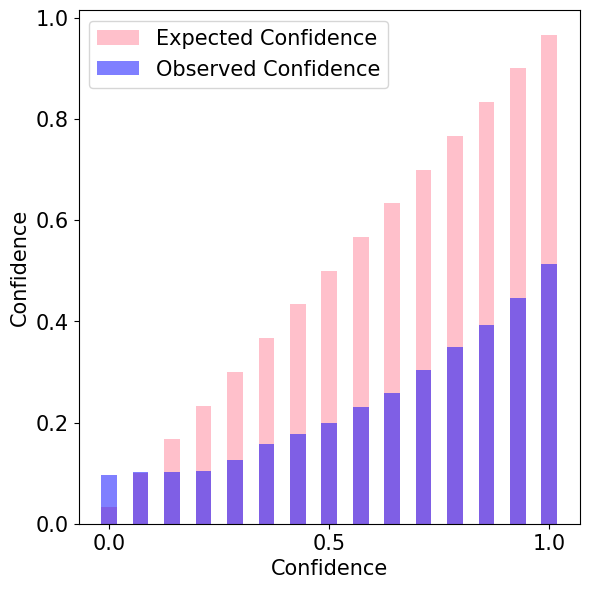

gamma:  5 Soft Cross Entropy Consistency:  0.14118351962716047
Accuracy:  0.3531999886035919


In [77]:
model_soft_ce = DNN(dimension, 100, num_classes).cuda()
optimizer_soft_ce = optim.SGD(model_soft_ce.parameters(), lr=learning_rate)
pbar_soft_ce = tqdm(total=len(train_loader))
soft_ce = SoftCE(gamma=gamma).cuda()

for epoch in range(5):
  for i, (inputs, labels) in enumerate(train_loader):
    inputs = inputs.cuda()
    labels = labels.cuda()
    optimizer_soft_ce.zero_grad()
    outputs = model_soft_ce(inputs)
    gt_probs, gt_distances = mog_data.compute_likelihood_ratio(labels.cpu(), inputs.cpu()) 
    gt_probs = torch.from_numpy(gt_probs).cuda()
    normalized_gt_distances = gt_distances / gt_distances.sum(axis=1, keepdims=True)
    normalized_gt_distances = torch.from_numpy(normalized_gt_distances).cuda()
    loss_prob = soft_ce(outputs, labels, normalized_gt_distances, gt_probs)
    loss_prob.backward()
    optimizer_soft_ce.step()
    pbar_soft_ce.update(1)
  print("Epoch: ", epoch, "Loss: ", loss_prob.item())
pbar_soft_ce.close()

test_outputs_soft_ce = model_soft_ce(test_data_tensor)
prob_soft_ce = F.softmax(test_outputs_soft_ce, dim=1)
confidence = prob_soft_ce.gather(1, test_labels.unsqueeze(1)).squeeze(1) 
calibrated_error_soft_ce = test_gt_probs - confidence
show(test_gt_probs, confidence, 'output_soft.pdf')
print("gamma: ", gamma, "Soft Cross Entropy Consistency: ", calibrated_error_soft_ce.abs().mean().item())
accuracy = (prob_ce_prob.argmax(dim=1) == test_labels).float().mean().item()
print("Accuracy: ", accuracy)

In [ ]:
def generate_mesh(min_x, max_x, min_y, max_y, num_x, num_y):
  # Define the range of x and y values
  x_range = np.linspace(-5, 5, num_x)
  y_range = np.linspace(-5, 5, num_y)

  # Generate the grid of points
  X, Y = np.meshgrid(x_range, y_range)
  print(X.shape)
  print(Y.shape)

  mesh = np.stack((X.reshape(-1),Y.reshape(-1)), axis=1)
  print(mesh.shape)
  return mesh

min_x = min_y = -500
max_x = max_y = 500
num_x = num_y = 101

mesh_np = generate_mesh(min_x=min_x, max_x=max_x, min_y=min_y, max_y=max_y, num_x=num_x, num_y=num_y).astype(np.float32)

inputs = torch.from_numpy(mesh_np)
outputs = model_ce(inputs)
pred_probs = F.softmax(outputs)[:, 0].detach().numpy()
print(mesh_np.shape)
print(mesh_np[100])
gt_probs = mog_data.compute_likelihood_ratio(mesh_np)


In [ ]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

# set_seed(18222)


# Select points with probabilities between 0.8 and 0.85, give back the indices
selected_indices = torch.where((test_pred_probs > 0.7) & (test_pred_probs < 0.85))
# selected_indices = torch.where(test_pred_probs > 0.0)

# randomly sample 1 number from the selected indices
poi_index = random.choice(selected_indices[0].numpy())
poi_data = test_data[poi_index]
poi_label = test_labels[poi_index]
poi_pred_prob = test_pred_probs[poi_index]
poi_pred_label = test_pred_labels[poi_index]

# compute the likelihood ratio for the poi_data
poi_gt_prob = mog_data.compute_likelihood_ratio(poi_data) if poi_pred_label == 0 else 1 - mog_data.compute_likelihood_ratio(poi_data)

print(f"The POI is {poi_data} with label {poi_label} and prediction probability {poi_pred_prob} and prediction label {poi_pred_label}")
print(f"The ground truth probability of the POI is {poi_gt_prob}")

# get the points with confidence around poi_pred_prob less than 0.01
confidence_gap = 0.03
confidence_high_threshold = poi_pred_prob + confidence_gap/2
confidence_low_threshold = poi_pred_prob - confidence_gap/2
# get the indices of the points with confidence around poi_pred_prob less than 0.01
confidence_indices = torch.where((test_pred_probs > confidence_low_threshold) & (test_pred_probs < confidence_high_threshold))
calibration_error_acc = (test_pred_labels[confidence_indices] == test_labels[confidence_indices]).sum()/len(confidence_indices[0])
print(f"The accuracy of the {len(confidence_indices[0])} points with confidence gap {confidence_gap} around point of interest {poi_pred_prob} is {calibration_error_acc}")
print(f"The gap between the accuracy and the ground truth probability of the POI is {abs(calibration_error_acc - poi_gt_prob)}")


eps = 0.61
poi_data_around = poi_data + np.random.uniform(-eps, eps, size=(1000,) + poi_data.shape)

# calculate the predicted label of these neighboring points
output_labels_around = model(torch.from_numpy(poi_data_around).float())
pred_labels_around = torch.max(output_labels_around, dim=1)[1]
pred_labels_conf = torch.max(F.softmax(output_labels_around, dim=1), dim=1)[0]


aggregation_result = pred_labels_around.sum()/len(pred_labels_around)
aggregation_result = max(aggregation_result.item(), 1 - aggregation_result.item())
print(f"The consistency eps: {eps:.2f}, pred_labels_around: {aggregation_result}")
print(f"The gap between the consistency (eps={eps:.2f}) and the ground truth probability of the POI is {abs(aggregation_result - poi_gt_prob)}")


In [ ]:
for i in range(1000):
    # sample 1000 points around the poi_data, the distance is sampled from a uniform distribution between 0 and 0.1
    eps = i/1000
    poi_data_around = poi_data + np.random.uniform(-eps, eps, size=(1000,) + poi_data.shape)

    # calculate the predicted label of these neighboring points
    output_labels_around = model(torch.from_numpy(poi_data_around).float())
    pred_labels_around = torch.max(output_labels_around, dim=1)[1]
    pred_labels_conf = torch.max(F.softmax(output_labels_around), dim=1)[0]

    
    aggregation_result = pred_labels_around.sum()/len(pred_labels_around)
    print("eps: ", eps, "pred_labels_around: ", aggregation_result if aggregation_result > 0.5 else 1 - aggregation_result)

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(np.flip(pred_probs.reshape(num_x, num_y), axis=0),cmap='jet')
cbar = fig.colorbar(im)
cbar.set_ticks([0,.25,.5,.75,1])
cbar.set_ticklabels([0,.25,.5,.75,1])
cbar.outline.set_linewidth(0)
ax.axis(False)
plt.show()

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(np.flip(gt_probs.reshape(num_x, num_y), axis=0),cmap='jet')
cbar = fig.colorbar(im)
cbar.set_ticks([0,.25,.5,.75,1])
cbar.set_ticklabels([0,.25,.5,.75,1])
cbar.outline.set_linewidth(0)
ax.axis(False)
plt.show()

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(np.flip((pred_probs-gt_probs).reshape(num_x, num_y), axis=0),cmap='hsv')
cbar = fig.colorbar(im)
cbar.set_ticks([-.2, -.1, 0,.1, .2])
cbar.set_ticklabels([-.2, -.1, 0,.1, .2])
cbar.outline.set_linewidth(0)
ax.axis(False)
plt.show()